# Deep Neural Collaborative Filtering

Use concatenate and dot product to build the deep recommender model

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item_withencoder, random_split, user_split_cap, remove_year

In [3]:
%matplotlib inline

### Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item_withencoder(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1663


In [6]:
DATA.head()

,USER,ITEM,RATING,TIMESTAMP
0,195,241,3,881250949
1,185,301,3,891717742
2,21,375,1,878887116
3,243,50,2,880606923
4,165,344,1,886397596


In [7]:
df_items['cleaned_title'] = df_items['title'].apply(remove_year)
df_items.head()

,movie_id,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Thriller,War,Western,year,overview,original_language,runtime,vote_average,vote_count,cleaned_title
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,1995.0,"Led by Woody, Andy's toys live happily in his ...",en,81.0,7.9,10878.0,Toy Story
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,1,0,0,1995.0,James Bond must unmask the mysterious head of ...,en,130.0,6.8,2037.0,GoldenEye
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,1,0,0,1995.0,It's Ted the Bellhop's first night on the job....,en,98.0,6.1,1251.0,Four Rooms
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,1995.0,Chili Palmer is a Miami mobster who gets sent ...,en,105.0,6.5,501.0,Get Shorty
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,1,0,0,1995.0,An agoraphobic psychologist and a female detec...,en,124.0,6.5,424.0,Copycat


In [8]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1663)

In [9]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [10]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = user_split_cap(DATA, [0.8, 0.2])

In [11]:
train.shape, test.shape

((79857, 5), (19958, 5))

## Deep Neural CF

This is a model with both dot and concatenate layers

In [12]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape, Concatenate, Dense
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils import plot_model
from keras.utils import model_to_dot
#from reco import vis

### Build the Model

In [13]:
def Neural_CF(n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    
    # Item Embedding MF
    item_embedding_mf = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                                  embeddings_initializer='he_normal',
                                  name='ItemEmbeddingMF')(item_input)
    item_vec_mf = Flatten(name='FlattenItemMF')(item_embedding_mf)
    
    
    # Item embedding MLP
    item_embedding_mlp = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                                embeddings_initializer='he_normal',
                               name='ItemEmbeddingMLP')(item_input)
    item_vec_mlp = Flatten(name='FlattenItemMLP')(item_embedding_mlp)
    

    # User Layer
    user_input = Input(shape=[1], name='User')
    
    # User Embedding MF
    user_embedding_mf = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6), 
                                embeddings_initializer='he_normal',
                               name='UserEmbeddingMF')(user_input)
    user_vec_mf = Flatten(name='FlattenUserMF')(user_embedding_mf)
    
    # User Embedding MF
    user_embedding_mlp = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='he_normal',
                               name='UserEmbeddingMLP')(user_input)
    user_vec_mlp = Flatten(name='FlattenUserMLP')(user_embedding_mlp)
    
    # Multiply MF paths
    DotProductMF = Dot(axes=1, name='DotProductMF')([item_vec_mf, user_vec_mf])
    
    # Concat MLP paths
    ConcatMLP = Concatenate(name='ConcatMLP')([item_vec_mlp, user_vec_mlp])
    
    # Use Dense to learn non-linear dense representation
    Dense_1 = Dense(50, name="Dense1")(ConcatMLP)
    Dense_2 = Dense(20, name="Dense2")(Dense_1)

    # Concatenate MF and MLP paths
    Concat = Concatenate(name="ConcatAll")([DotProductMF, Dense_2])
    
    # Use Dense to learn non-linear dense representation
    Pred = Dense(1, name="Pred")(Concat)
    

    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-5), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-5), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Pred with bias added
    PredAddBias = Add(name="AddBias")([Pred, item_bias_vec, user_bias_vec])
    
    
    # Scaling for each user
    y = Activation('sigmoid')(PredAddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [14]:
n_factors = 40
model = Neural_CF(n_users, n_items, n_factors)

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemEmbeddingMLP (Embedding)  │ (None, 1, 40)             │          66,520 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserEmbeddingMLP (Embedding)  │ (None, 1, 40)             │          37,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemMLP (Flatten)      │ (None, 40)                │               0 │ ItemEmbeddingMLP[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUserMLP (Flatten)      │ (None, 40)                │               0 │ UserEmbeddingMLP[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemEmbeddingMF (Embedding)   │ (None, 1, 40)             │          66,520 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserEmbeddingMF (Embedding)   │ (None, 1, 40)             │          37,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ConcatMLP (Concatenate)       │ (None, 80)                │               0 │ FlattenItemMLP[0][0],      │
│                               │                           │                 │ FlattenUserMLP[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemMF (Flatten)       │ (None, 40)                │               0 │ ItemEmbeddingMF[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUserMF (Flatten)       │ (None, 40)                │               0 │ UserEmbeddingMF[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dense1 (Dense)                │ (None, 50)                │           4,050 │ ConcatMLP[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ DotProductMF (Dot)            │ (None, 1)                 │               0 │ FlattenItemMF[0][0],       │
│                               │                           │                 │ FlattenUserMF[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dense2 (Dense)                │ (None, 20)                │           1,020 │ Dense1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ConcatAll (Concatenate)       │ (None, 21)                │               0 │ DotProductMF[0][0],        │
│                               │                           │                 │ Dense2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemBias (Embedding)          │ (None, 1, 1)              │           1,66

 Total params: 216,178 (844.45 KB)

 Trainable params: 216,178 (844.45 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from reco.recoutils import create_directory
create_directory("/model-img")

Directory already exists C:\Users\sadha\OneDrive\Desktop\Movie Recommendation System/model-img


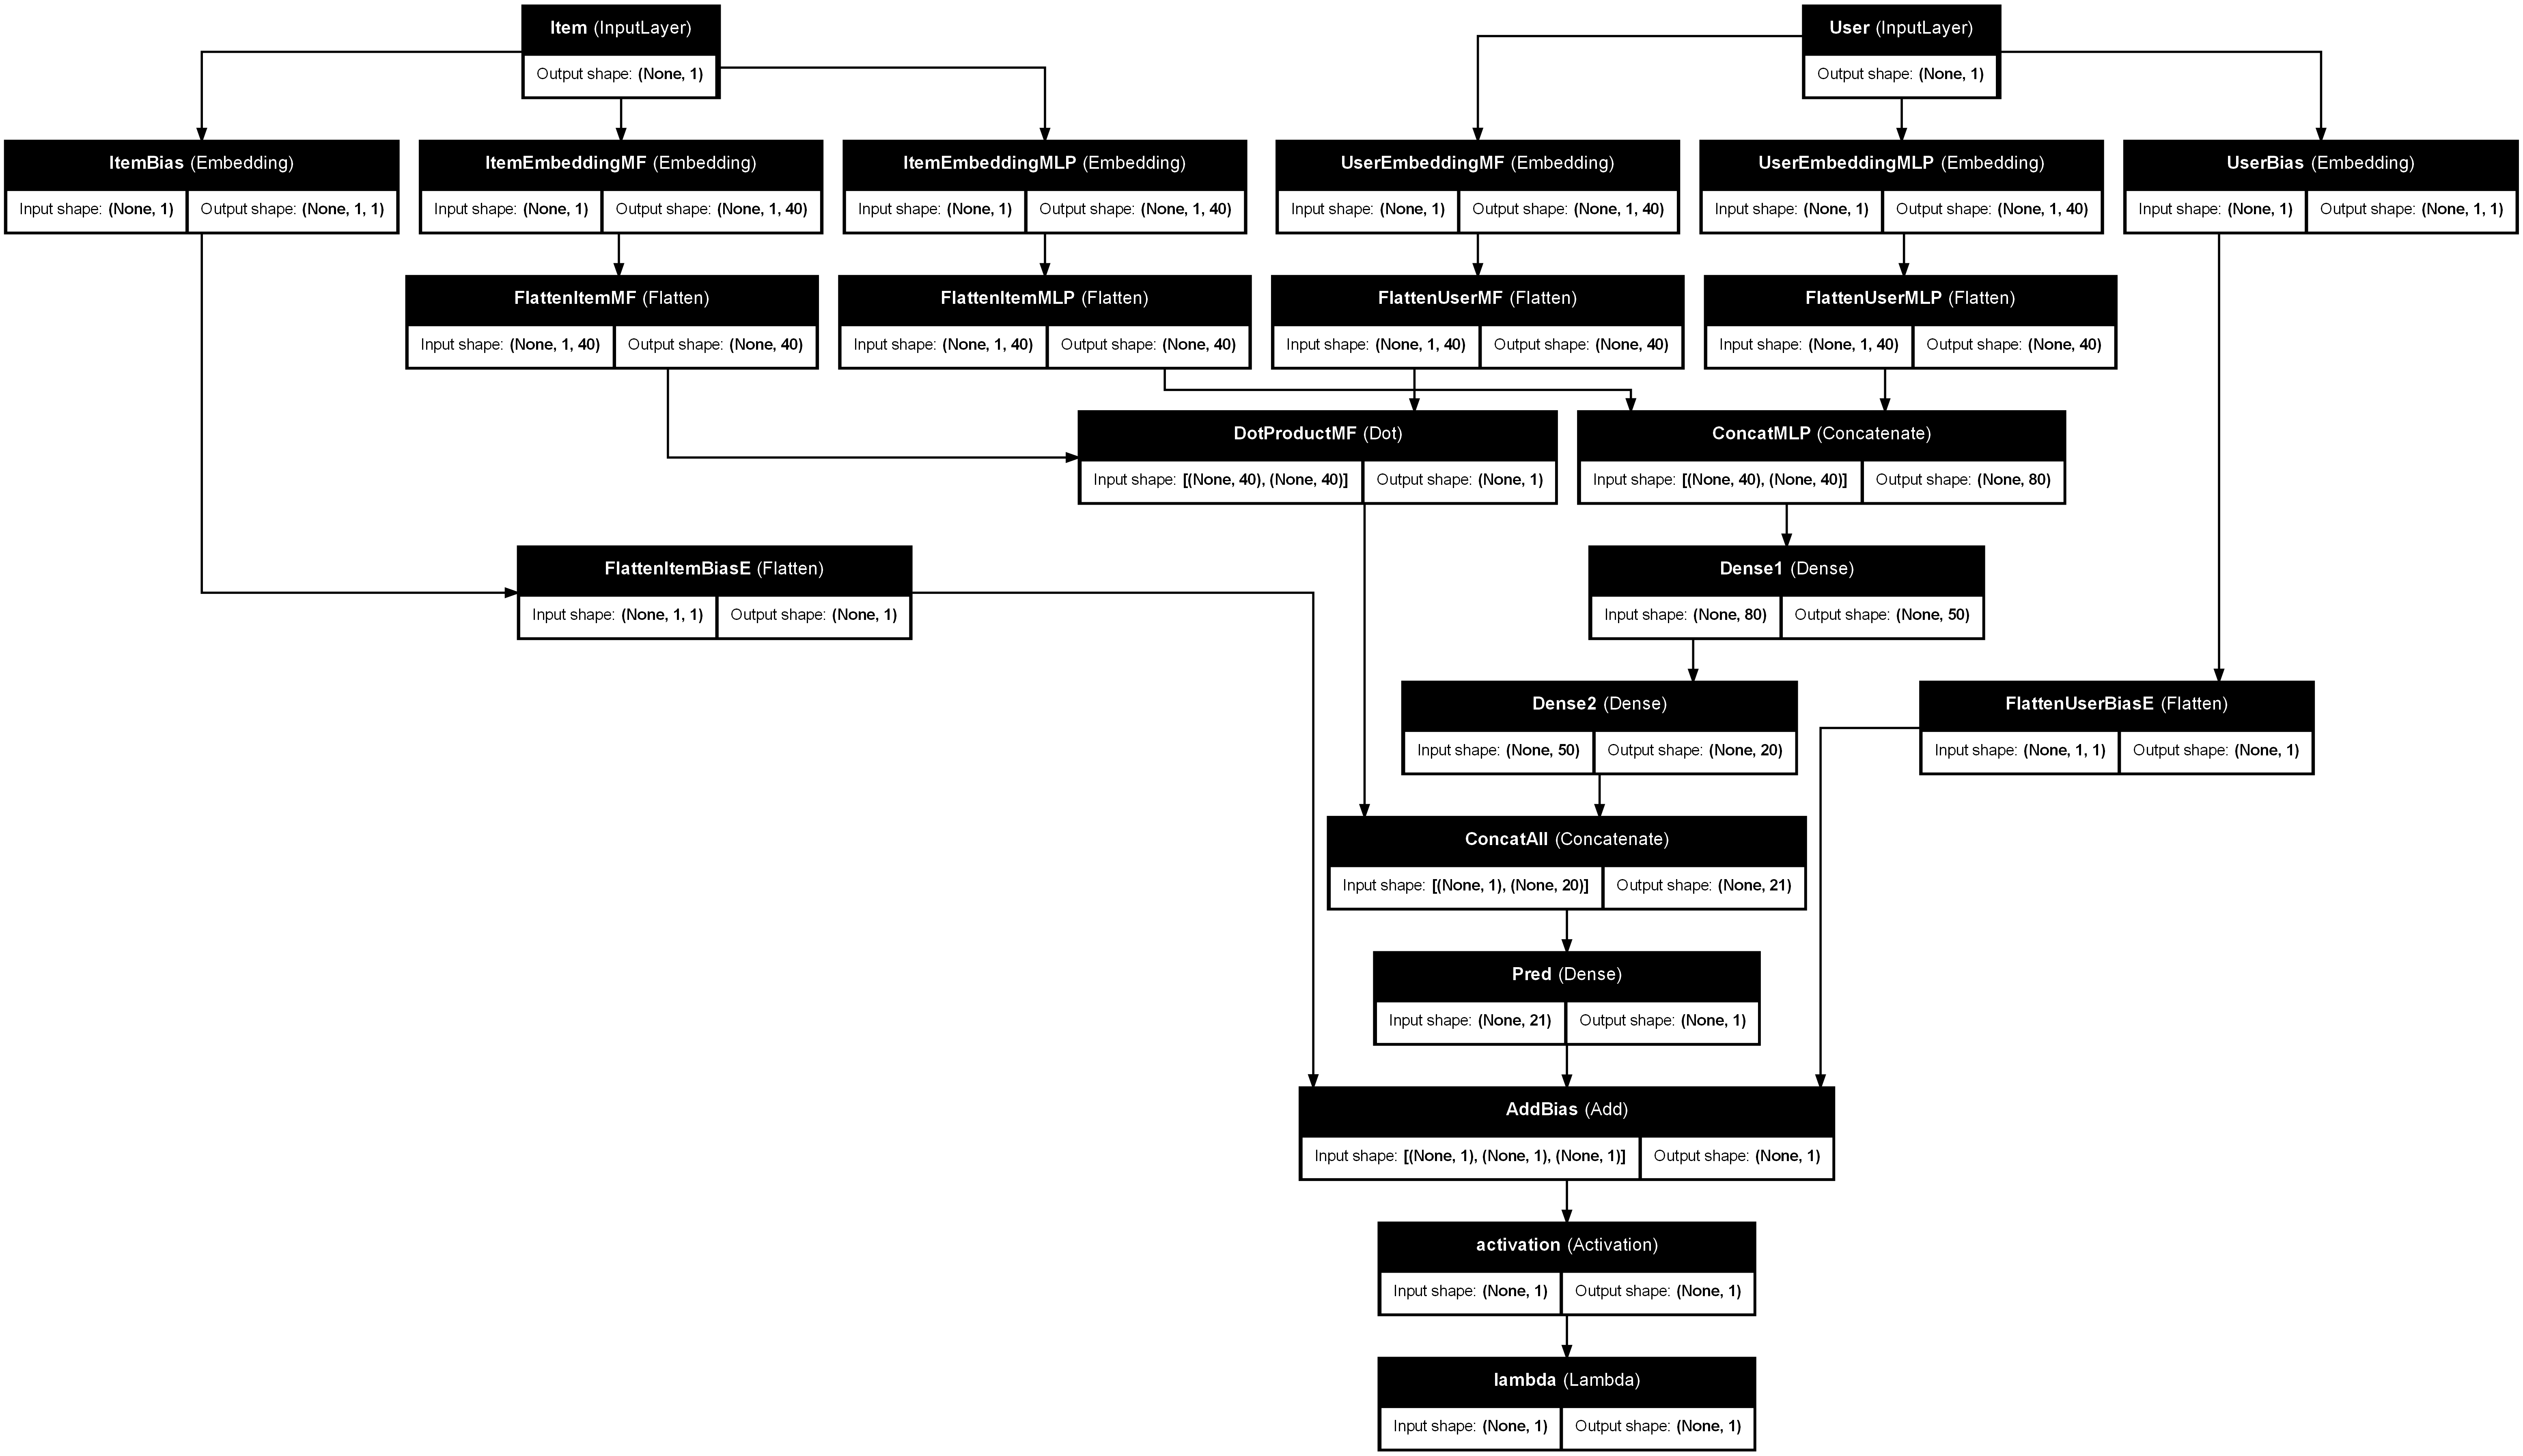

In [17]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/Neural-CF.png" )

### Train the Model

In [18]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - loss: 1.0862 - val_loss: 1.0114
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.8702 - val_loss: 1.0019
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.7488 - val_loss: 1.0073
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5134 - val_loss: 1.0079
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3703 - val_loss: 1.0120
Wall time: 49.2 s


In [19]:
#vis.metrics(output.history)

### Score the Model

In [20]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9789


0.9927610754966736

### Evaluate the Model

In [21]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [22]:
item_embedding_mf = get_embedding(model, "ItemEmbeddingMF")
user_embedding_mf = get_embedding(model, "UserEmbeddingMF")
item_embedding_mlp = get_embedding(model, "ItemEmbeddingMLP")
user_embedding_mlp = get_embedding(model, "UserEmbeddingMLP")

In [23]:
item_embedding = np.mean([item_embedding_mf,item_embedding_mlp], axis=0)
user_embedding = np.mean([user_embedding_mf,user_embedding_mlp], axis=0)

In [24]:
%%time
predictions = get_predictions(model, DATA)

49007/49007 ━━━━━━━━━━━━━━━━━━━━ 445s 9ms/step
Wall time: 12min 7s


In [25]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,4.063297
1,195,301,3.704493
2,195,375,2.244789
3,195,50,4.273086
4,195,344,3.337031


In [26]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49007/49007 ━━━━━━━━━━━━━━━━━━━━ 401s 8ms/step
Wall time: 10min 52s


In [27]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.072595
Precision@K:	0.051962
Recall@K:	0.022871


### Get Similar Items

In [28]:
from reco.recommend import get_similar, show_similar

In [29]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

Wall time: 390 ms


In [30]:
item_similar_indices

array([[   0,  527, 1218,  604, 1583],
       [   1,  910, 1345, 1416, 1208],
       [   2, 1441, 1586,  443, 1577],
       ...,
       [1660, 1645, 1647, 1114, 1643],
       [1661, 1402, 1547, 1114, 1654],
       [1662, 1331, 1559, 1654, 1643]], dtype=int64)

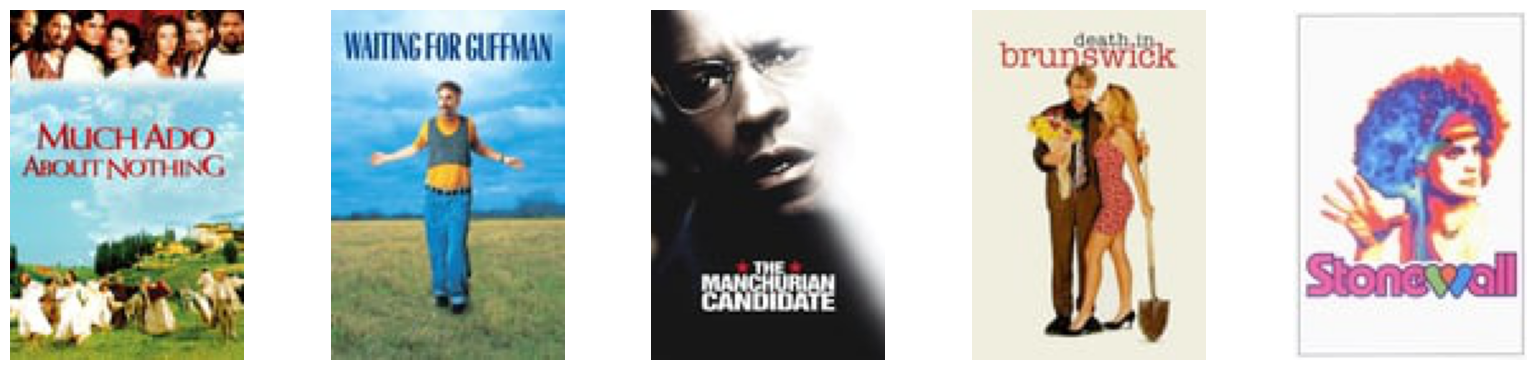

In [38]:
show_similar("jurassic park", item_similar_indices, item_encoder, df_items)